# 1. 2D
## 1.1. Dispersion relation of bulk
### 1.1.1. inertial frame of reference

(84, 73, 4) (84, 73, 4, 4)


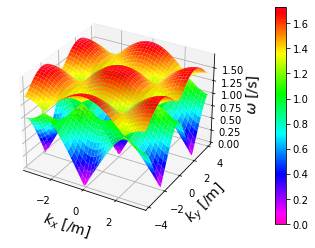

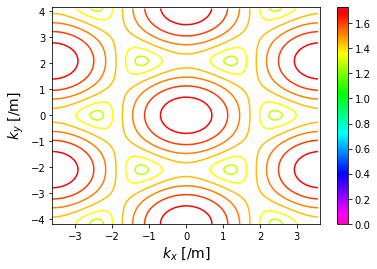

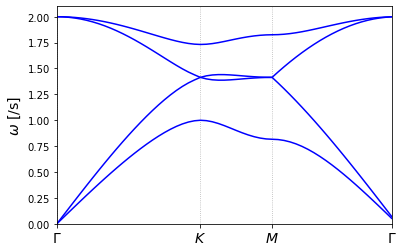

In [36]:
import torch
from conut import MechanicalGrapheneBulk


dev = 'cuda' if torch.cuda.is_available() else 'cpu'

mg = MechanicalGrapheneBulk(κ=1, α=1, m=1, l=1, precision=1e-1, perturbation=False).to(dev)
evals_all, evecs_all = mg.dispersion()


# 3D dispersion
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(mg.kxs, mg.kys)

vmax = np.amax(np.sqrt(evals_all[:, :, 2]).real)
ax.plot_surface(X, Y, np.sqrt(evals_all[:, :, 1]).real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 
p = ax.plot_surface(X, Y, np.sqrt(evals_all[:, :, 2]).real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 

ax.set_xlabel(r"$k_x$ [/m]", fontsize=14)
ax.set_xlim(-xw, xw)
ax.set_ylabel(r"$k_y$ [/m]", fontsize=14)
ax.set_ylim(-yw, yw)
ax.set_zlabel(r"$\omega$ [/s]", fontsize=14)
ax.set_zlim(0)

fig.colorbar(p, pad=0.15)
# fig.savefig("2d-graphene-dispersion-3d.png")
plt.show()


# Contour plot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
fig, ax = plt.subplots()
X, Y = np.meshgrid(kxs, kys)

vmax = np.amax(np.sqrt(evals_all[:, :, 2]).real)
cs = plt.contour(X, Y, np.sqrt(evals_all[:, :, 2]).real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 

plt.xlabel(r"$k_x$ [/m]",  fontsize=14)
plt.xlim(-xw, xw)
plt.ylabel(r"$k_y$ [/m]", fontsize=14)
plt.ylim(-yw, yw)


norm= colors.Normalize(vmin=0., vmax=vmax)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cs.cmap)
sm.set_array([])
fig.colorbar(sm)
# fig.savefig("2d-graphene-dispersion-contour.png")
plt.show()


# Dispersion relation G1 -> K -> M -> G2
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1_ = 2 * np.pi / np.sqrt(3) / a * (x - y / np.sqrt(3)) 
a2_ = 4 * np.pi / 3 / a * y
G = np.array([[0.], [0.]])
K = (a1_ / 2 + a2_ / 4) / np.cos(np.pi / 6)**2
M = a1_ / 2

GK = (K - G)
KM = (M - K)
MG = (G - M)
gk = GK / la.norm(GK)
km = KM / la.norm(KM)
mg = MG / la.norm(MG)
num_gk = int(la.norm(GK) / precision)
num_km = int(la.norm(KM) / precision)
num_mg = int(la.norm(MG) / precision) + 1
kxs = np.hstack([
    [gk[0,0] * precision * i for i in range(num_gk)],
    [km[0,0] * precision * i + GK[0,0] for i in range(num_km)],
    [mg[0,0] * precision * i + GK[0,0] + KM[0,0] for i in range(num_mg)]
])
kys = np.hstack([
    [gk[1,0] * precision * i for i in range(num_gk)],
    [km[1,0] * precision * i + GK[1,0] for i in range(num_km)],
    [mg[1,0] * precision * i + GK[1,0] + KM[1,0] for i in range(num_mg)]
])


evals_all = []
for ky, kx in zip(kys, kxs):
    k = np.array([kx, ky])
    p = np.exp(1.j * k.dot(a1))
    s = np.exp(1.j * k.dot(a2))
    # H = w0**2 * np.vstack([
    #     np.hstack([R11 + R22 + R33, -(R11 + R22 * p.conj() + R33 * s.conj())]),
    #     np.hstack([-(R11 + R22 * p + R33 * s), R11 + R22 + R33]),
    # ])
    z = np.array([[0, 1], [-1, 0]])
    R1_ = z.dot(R1h)
    R2_ = z.dot(R2h)
    R3_ = z.dot(R3h)
    R11_ = R1_ * R1_.conj().T
    R22_ = R2_ * R2_.conj().T
    R33_ = R3_ * R3_.conj().T
    chi = 2/3
    g1 = (1 - chi) * R11_ + R11
    g2 = (1 - chi) * R22_ + R22
    g3 = (1 - chi) * R33_ + R33
    H = w0**2 * np.vstack([
        np.hstack([(R11 + R22 + R33) * (2-chi) , -(g1 + g2 * p.conj() + g3 * s.conj())]),
        np.hstack([-(g1 + g2 * p + g3 * s), (R11 + R22 + R33) * (2 - chi)]),
    ])
    evals, evecs = la.eig(H)
    idcs = np.argsort(evals)
    evals, evecs = evals[idcs], evecs[idcs]
    evals_all.append(evals)
evals_all = np.array(evals_all, dtype=np.complex128)


import matplotlib.pyplot as plt
fig = plt.figure()
dr = np.arange(0, precision * len(kxs), precision)
for i in range(4):
    plt.plot(dr, np.sqrt(evals_all[:, i]).real, color='blue')

xticks = [
    0, 
    num_gk * precision, 
    num_gk * precision + num_km * precision, 
    num_gk * precision + num_km * precision + (num_mg - 1) * precision
]
xlabels = [r"$\Gamma$", r"$K$", r"$M$", r"$\Gamma$"]
plt.xticks(xticks, xlabels, fontsize=14)
plt.grid(axis='x', linestyle='dotted')
plt.xlim(0, max(dr))
plt.ylabel(r"$\omega$ [/s]", fontsize=14)
plt.ylim(0)
plt.show()
# fig.savefig("2d-graphene-dispersion.png")

#### 1.1.1.1. Visualize eigenvectors

(84, 73, 4) (84, 73, 4, 4)


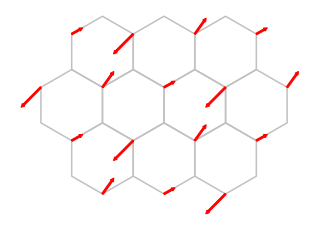

In [2]:
import numpy as np
import numpy.linalg as la



C = 1.
M = 1.
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1 = np.sqrt(3) * a * x
a2 = (np.sqrt(3) * x + 3 * y) * a / 2.
R1 = 1 / 3 * (a1 + a2)
R2 = 1 / 3 * (-2 * a1 + a2)
R3 = 1 / 3 * (a1 - 2 * a2)
R1h = R1 / la.norm(R1)
R2h = R2 / la.norm(R2)
R3h = R3 / la.norm(R3)
R11 = R1h * R1h.conj().T
R22 = R2h * R2h.conj().T
R33 = R3h * R3h.conj().T
precision = 1e-1
xw = np.pi / np.sqrt(3) * 2 # width of x
yw = np.pi / 3 * 4 # width of y
kxs = np.arange(-xw, xw, precision)
kys = np.arange(-yw, yw, precision)


evals_all = np.zeros((len(kys), len(kxs), 4), dtype=np.complex128)
evecs_all = np.zeros((len(kys), len(kxs), 4, 4), dtype=np.complex128)
for y, ky in enumerate(kys):
    for x, kx in enumerate(kxs):
        k = np.array([kx, ky])
        p = np.exp(1.j * k.dot(a1))
        s = np.exp(1.j * k.dot(a2))
        H = w0**2 * np.vstack([
            np.hstack([R11 + R22 + R33, -(R11 + R22 * p.conj() + R33 * s.conj())]),
            np.hstack([-(R11 + R22 * p + R33 * s) ,R11 + R22 + R33]),
        ])
        evals, evecs = la.eigh(H)
        idcs = np.argsort(evals)
        evals, evecs = evals[idcs], evecs[idcs]
        evals_all[y, x] = evals
        evecs_all[y, x] = evecs
evals_all = np.array(evals_all)
evecs_all = np.array(evecs_all)
print(evals_all.shape, evecs_all.shape)




x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1_ = 2 * np.pi / np.sqrt(3) / a * (x - y / np.sqrt(3)) 
a2_ = 4 * np.pi / 3 / a * y
G = np.array([[0.], [0.]])
K = (a1_ / 2 + a2_ / 4) / np.cos(np.pi / 6)**2
M = a1_ / 2

# Parameters #
kx = K[0] 
ky = K[1] 
mode = 2 # 1 or 2
###############

a1 = np.sqrt(3) * a * np.array([1, 0])
a2 = (np.sqrt(3) * np.array([1, 0]) + 3 * np.array([0, 1])) * a / 2.

k = np.array([kx[0], ky[0]])
p = np.exp(1.j * k.dot(a1))
s = np.exp(1.j * k.dot(a2))
idx = min(range(len(kxs)), key=lambda i: abs(kxs[i]-kx[0]))
idy = min(range(len(kys)), key=lambda i: abs(kys[i]-ky[0]))
vec = evecs_all[idy, idx, mode]
xi = vec[:2]
eta = vec[2:4]


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

dx = np.sqrt(3)
offCoord = [
    [0,-.5], [dx,-.5], [2*dx,-.5],
    [0,-.5] - a2, [dx,-.5] - a2, [2*dx,-.5] - a2, [3*dx,-.5] - a2,
    [0,-.5] - 2*a2 + a1, [dx,-.5] - 2*a2 + a1, [2*dx,-.5] - 2*a2 + a1
]

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

for c in offCoord:
    hexagon = RegularPolygon((c[0] + np.sqrt(3) / 2, c[1]), numVertices=6, radius=a, ec='silver', fill=False, lw=1.5)
    ax.add_patch(hexagon)
plt.autoscale(enable = True)
# Xi
for i in range(4):
    xi_ = (xi * p**i).real
    pos = i * a1
    ax.arrow(pos[0], pos[1], xi_[0], xi_[1], width=0.05, head_width=0.1, head_length=0.1, fc='r', ec='r')
for i in range(5):
    xi_ = (xi * s.conj() * p**i).real
    pos = i * a1 - a2
    ax.arrow(pos[0], pos[1], xi_[0], xi_[1], width=0.05, head_width=0.1, head_length=0.1, fc='r', ec='r')
for i in range(4):
    xi_ = (xi * s.conj()**2 * p**(i + 1)).real
    pos = (i + 1) * a1 - 2 * a2
    ax.arrow(pos[0], pos[1], xi_[0], xi_[1], width=0.05, head_width=0.1, head_length=0.1, fc='r', ec='r')
for i in range(3):
    xi_ = (xi * s.conj()**3 * p**(i + 2)).real
    pos = (i + 2) * a1 - 3 * a2
    ax.arrow(pos[0], pos[1], xi_[0], xi_[1], width=0.05, head_width=0.1, head_length=0.1, fc='r', ec='r')
plt.axis('off')
plt.show()


### 1.1.2. Coriolis

(84, 73, 8) (84, 73, 8, 8)


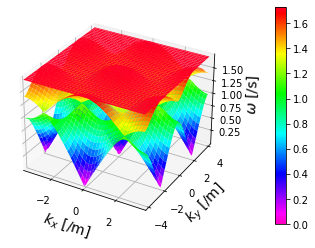

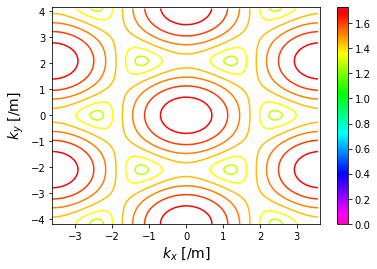

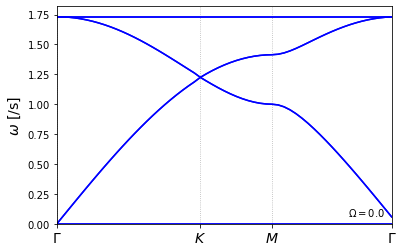

In [15]:
import numpy as np
import numpy.linalg as la


O = 0
C = 1.
M = 1.
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1 = np.sqrt(3) * a * x
a2 = (np.sqrt(3) * x + 3 * y) * a / 2.
R1 = 1 / 3 * (a1 + a2)
R2 = 1 / 3 * (-2 * a1 + a2)
R3 = 1 / 3 * (a1 - 2 * a2)
R1h = R1 / la.norm(R1)
R2h = R2 / la.norm(R2)
R3h = R3 / la.norm(R3)
R11 = R1h * R1h.conj().T
R22 = R2h * R2h.conj().T
R33 = R3h * R3h.conj().T
Rw = np.array([[0., -1.], [1., 0.]])
precision = 1e-1
xw = np.pi / np.sqrt(3) * 2 # width of x
yw = np.pi / 3 * 4 # width of y
kxs = np.arange(-xw, xw, precision)
kys = np.arange(-yw, yw, precision)


evals_all = np.zeros((len(kys), len(kxs), 8), dtype=np.complex128)
evecs_all = np.zeros((len(kys), len(kxs), 8, 8), dtype=np.complex128)
for y, ky in enumerate(kys):
    for x, kx in enumerate(kxs):
        k = np.array([kx, ky])
        p = np.exp(1.j * k.dot(a1))
        s = np.exp(1.j * k.dot(a2))
        L11 = np.vstack([
            np.hstack([R11 + R22 + R33, -(R11 + p.conj() * R22 + s.conj() * R33)]),
            np.hstack([-(R11 + p * R22 + s * R33), R11 + R22 + R33])
        ])
        L12 = np.vstack([
            np.hstack([-Rw * 2.j * O, np.zeros((2, 2))]),
            np.hstack([np.zeros((2, 2)), -Rw * 2.j * O])
        ])
        L = w0 ** 2 * np.vstack([
            np.hstack([L11, L12]),
            np.hstack([np.zeros((4, 4)), np.eye(4)])
        ])
        M = np.vstack([
            np.hstack([np.zeros((4, 4)), np.eye(4)]),
            np.hstack([np.eye(4), np.zeros((4, 4))])
        ])

        H = np.linalg.inv(M).dot(L)
        evals, evecs = la.eig(H)
        idcs = np.argsort(evals)
        evals, evecs = evals[idcs], evecs[idcs]
        evals_all[y, x] = evals
        evecs_all[y, x] = evecs
evals_all = np.array(evals_all)
evecs_all = np.array(evecs_all)
print(evals_all.shape, evecs_all.shape)


# 3D dispersion
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(kxs, kys)

vmax = np.amax(evals_all[:, :, 7].real)
ax.plot_surface(X, Y, evals_all[:, :, 5].real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 
ax.plot_surface(X, Y, evals_all[:, :, 6].real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 
p = ax.plot_surface(X, Y, evals_all[:, :, 7].real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 
ax.set_xlabel(r"$k_x$ [/m]", fontsize=14)
ax.set_xlim(-xw, xw)
ax.set_ylabel(r"$k_y$ [/m]", fontsize=14)
ax.set_ylim(-yw, yw)
ax.set_zlabel(r"$\omega$ [/s]", fontsize=14)
# ax.set_zlim(0)

fig.colorbar(p, pad=0.15)
fig.savefig("2dc-graphene-dispersion-3d-" + f'{O:.1f}' + ".png")
plt.show()


# Contour plot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
fig, ax = plt.subplots()
X, Y = np.meshgrid(kxs, kys)

vmax = np.amax(evals_all[:, :, 6].real)
cs = plt.contour(X, Y, evals_all[:, :, 6].real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 

plt.xlabel(r"$k_x$ [/m]", fontsize=14)
plt.xlim(-xw, xw)
plt.ylabel(r"$k_y$ [/m]", fontsize=14)
plt.ylim(-yw, yw)


norm= colors.Normalize(vmin=0., vmax=vmax)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cs.cmap)
sm.set_array([])
fig.colorbar(sm)
fig.savefig("2dc-graphene-dispersion-contour-" + f'{O:.1f}' + ".png")
plt.show()


# Dispersion relation G -> K -> M -> G
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1_ = 2 * np.pi / np.sqrt(3) / a * (x - y / np.sqrt(3)) 
a2_ = 4 * np.pi / 3 / a * y
G = np.array([[0.], [0.]])
K = (a1_ / 2 + a2_ / 4) / np.cos(np.pi / 6)**2
M = a1_ / 2

GK = (K - G)
KM = (M - K)
MG = (G - M)
gk = GK / la.norm(GK)
km = KM / la.norm(KM)
mg = MG / la.norm(MG)
num_gk = int(la.norm(GK) / precision)
num_km = int(la.norm(KM) / precision)
num_mg = int(la.norm(MG) / precision) + 1
kxs = np.hstack([
    [gk[0,0] * precision * i for i in range(num_gk)],
    [km[0,0] * precision * i + GK[0,0] for i in range(num_km)],
    [mg[0,0] * precision * i + GK[0,0] + KM[0,0] for i in range(num_mg)]
])
kys = np.hstack([
    [gk[1,0] * precision * i for i in range(num_gk)],
    [km[1,0] * precision * i + GK[1,0] for i in range(num_km)],
    [mg[1,0] * precision * i + GK[1,0] + KM[1,0] for i in range(num_mg)]
])


evals_all = []
for ky, kx in zip(kys, kxs):
    k = np.array([kx, ky])
    p = np.exp(1.j * k.dot(a1))
    s = np.exp(1.j * k.dot(a2))
    L11 = np.vstack([
        np.hstack([R11 + R22 + R33, -(R11 + p.conj() * R22 + s.conj() * R33)]),
        np.hstack([-(R11 + p * R22 + s * R33), R11 + R22 + R33])
    ])
    L12 = np.vstack([
        np.hstack([-Rw * 2.j * O, np.zeros((2, 2))]),
        np.hstack([np.zeros((2, 2)), -Rw * 2.j * O])
    ])
    L = w0 ** 2 * np.vstack([
        np.hstack([L11, L12]),
        np.hstack([np.zeros((4, 4)), np.eye(4)])
    ])
    M = np.vstack([
        np.hstack([np.zeros((4, 4)), np.eye(4)]),
        np.hstack([np.eye(4), np.zeros((4, 4))])
    ])
    H = np.linalg.inv(M).dot(L)
    evals, evecs = la.eig(H)
    idcs = np.argsort(evals)
    evals, evecs = evals[idcs], evecs[idcs]
    evals_all.append(evals)
evals_all = np.array(evals_all, dtype=np.complex128)


import matplotlib.pyplot as plt
fig = plt.figure()
dr = np.arange(0, precision * len(kxs), precision)
for i in range(8):
    plt.plot(dr, abs(evals_all[:, i].real), color='blue')

xticks = [
    0, 
    num_gk * precision, 
    num_gk * precision + num_km * precision, 
    num_gk * precision + num_km * precision + (num_mg - 1) * precision
]
xlabels = [r"$\Gamma$", r"$K$", r"$M$", r"$\Gamma$"]
plt.xticks(xticks, xlabels, fontsize=14)
plt.grid(axis='x', linestyle='dotted')
plt.xlim(0, max(dr))
plt.ylabel(r"$\omega$ [/s]", fontsize=14)
plt.figtext(.8, .15, r"$\Omega=$" + f'{O:.1f}', fontsize=10)
plt.ylim(0)
plt.show()
fig.savefig("2dc-graphene-dispersion-" + f'{O:.1f}' + ".png")


#### 1.1.2.1. Visualize eigenvectors

(84, 73, 8) (84, 73, 8, 8)


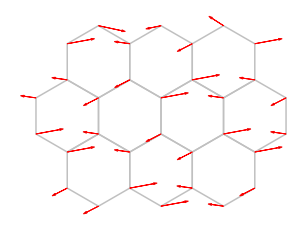

In [4]:
import numpy as np
import numpy.linalg as la

O = 1.6
C = 1.
M = 1.
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1 = np.sqrt(3) * a * x
a2 = (np.sqrt(3) * x + 3 * y) * a / 2.
R1 = 1 / 3 * (a1 + a2)
R2 = 1 / 3 * (-2 * a1 + a2)
R3 = 1 / 3 * (a1 - 2 * a2)
R1h = R1 / la.norm(R1)
R2h = R2 / la.norm(R2)
R3h = R3 / la.norm(R3)
R11 = R1h * R1h.conj().T
R22 = R2h * R2h.conj().T
R33 = R3h * R3h.conj().T
Rw = np.array([[0., -1.], [1., 0.]])
precision = 1e-1
xw = np.pi / np.sqrt(3) * 2 # width of x
yw = np.pi / 3 * 4 # width of y
kxs = np.arange(-xw, xw, precision)
kys = np.arange(-yw, yw, precision)


evals_all = np.zeros((len(kys), len(kxs), 8), dtype=np.complex128)
evecs_all = np.zeros((len(kys), len(kxs), 8, 8), dtype=np.complex128)
for y, ky in enumerate(kys):
    for x, kx in enumerate(kxs):
        k = np.array([kx, ky])
        p = np.exp(1.j * k.dot(a1))
        s = np.exp(1.j * k.dot(a2))
        L11 = np.vstack([
            np.hstack([R11 + R22 + R33, -(R11 + p.conj() * R22 + s.conj() * R33)]),
            np.hstack([-(R11 + p * R22 + s * R33), R11 + R22 + R33])
        ])
        L12 = np.vstack([
            np.hstack([-Rw * 2.j * O, np.zeros((2, 2))]),
            np.hstack([np.zeros((2, 2)), -Rw * 2.j * O])
        ])
        L = w0 ** 2 * np.vstack([
            np.hstack([L11, L12]),
            np.hstack([np.zeros((4, 4)), np.eye(4)])
        ])
        M = np.vstack([
            np.hstack([np.zeros((4, 4)), np.eye(4)]),
            np.hstack([np.eye(4), np.zeros((4, 4))])
        ])

        H = np.linalg.inv(M).dot(L)
        evals, evecs = la.eig(H)
        idcs = np.argsort(evals)
        evals, evecs = evals[idcs], evecs[idcs]
        evals_all[y, x] = evals
        evecs_all[y, x] = evecs
evals_all = np.array(evals_all)
evecs_all = np.array(evecs_all)
print(evals_all.shape, evecs_all.shape)


x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1_ = 2 * np.pi / np.sqrt(3) / a * (x - y / np.sqrt(3)) 
a2_ = 4 * np.pi / 3 / a * y
G = np.array([[0.], [0.]])
K = (a1_ / 2 + a2_ / 4) / np.cos(np.pi / 6)**2
M = a1_ / 2

# Parameters #
kx = K[0] 
ky = K[1] 
mode = 5 # 1 or 2
###############

a1 = np.sqrt(3) * a * np.array([1, 0])
a2 = (np.sqrt(3) * np.array([1, 0]) + 3 * np.array([0, 1])) * a / 2.

k = np.array([kx[0], ky[0]])
p = np.exp(1.j * k.dot(a1))
s = np.exp(1.j * k.dot(a2))
idx = min(range(len(kxs)), key=lambda i: abs(kxs[i]-kx[0]))
idy = min(range(len(kys)), key=lambda i: abs(kys[i]-ky[0]))
vec = evecs_all[idy, idx, mode]
xi = vec[:2]
eta = vec[2:4]


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

dx = np.sqrt(3)
offCoord = [
    [0,-.5], [dx,-.5], [2*dx,-.5],
    [0,-.5] - a2, [dx,-.5] - a2, [2*dx,-.5] - a2, [3*dx,-.5] - a2,
    [0,-.5] - 2*a2 + a1, [dx,-.5] - 2*a2 + a1, [2*dx,-.5] - 2*a2 + a1
]

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

for c in offCoord:
    hexagon = RegularPolygon((c[0] + np.sqrt(3) / 2, c[1]), numVertices=6, radius=a, ec='silver', fill=False, lw=1.5)
    ax.add_patch(hexagon)
plt.autoscale(enable = True)

def arrow(pos, vec):
    ax.arrow(pos[0], pos[1], vec[0], vec[1], head_width=0.05, head_length=0.1, fc='black', ec='red')
    
# Xi
for i in range(4):
    xi_ = (xi * p**i).real
    pos = i * a1
    arrow(pos, xi_)
for i in range(5):
    xi_ = (xi * s.conj() * p**i).real
    pos = i * a1 - a2
    arrow(pos, xi_)
for i in range(4):
    xi_ = (xi * s.conj()**2 * p**(i + 1)).real
    pos = (i + 1) * a1 - 2 * a2
    arrow(pos, xi_)
for i in range(3):
    xi_ = (xi * s.conj()**3 * p**(i + 2)).real
    pos = (i + 2) * a1 - 3 * a2
    arrow(pos, xi_)
# Eta
for i in range(3):
    eta_ = (eta * p**i).real
    pos = np.squeeze(R1) + i * a1
    arrow(pos, eta_)
for i in range(4):
    eta_ = (xi * s.conj() * p**i).real
    pos = np.squeeze(R1) + i * a1 - a2
    arrow(pos, eta_)
for i in range(5):
    eta_ = (xi * s.conj()**2 * p**(i + 1)).real
    pos = np.squeeze(R1) + i * a1 - 2 * a2
    arrow(pos, eta_)
for i in range(4):
    eta_ = (xi * s.conj()**3 * p**(i + 2)).real
    pos = np.squeeze(R1) + (i + 1) * a1 - 3 * a2
    arrow(pos, eta_)
plt.axis('off')
plt.show()



### 1.1.3. Coriolis as a perturbation

(84, 73, 4) (84, 73, 4, 4)


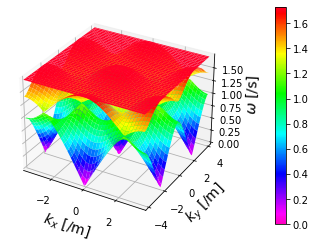

In [5]:
import numpy as np
import numpy.linalg as la



O = 0.
C = 1.
M = 1.
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1 = np.sqrt(3) * a * x
a2 = (np.sqrt(3) * x + 3 * y) * a / 2.
R1 = 1 / 3 * (a1 + a2)
R2 = 1 / 3 * (-2 * a1 + a2)
R3 = 1 / 3 * (a1 - 2 * a2)
R1h = R1 / la.norm(R1)
R2h = R2 / la.norm(R2)
R3h = R3 / la.norm(R3)
R11 = R1h * R1h.conj().T
R22 = R2h * R2h.conj().T
R33 = R3h * R3h.conj().T
Rw = np.array([[0., -1.], [1., 0.]])
precision = 1e-1
xw = np.pi / np.sqrt(3) * 2 # width of x
yw = np.pi / 3 * 4 # width of y
kxs = np.arange(-xw, xw, precision)
kys = np.arange(-yw, yw, precision)


evals_all = np.zeros((len(kys), len(kxs), 4), dtype=np.complex128)
evecs_all = np.zeros((len(kys), len(kxs), 4, 4), dtype=np.complex128)
for y, ky in enumerate(kys):
    for x, kx in enumerate(kxs):
        k = np.array([kx, ky])
        p = np.exp(1.j * k.dot(a1))
        s = np.exp(1.j * k.dot(a2))
        H = w0**2 * np.vstack([
            np.hstack([R11 + R22 + R33 - 2.j * O * Rw / w0**2, -(R11 + R22 * p.conj() + R33 * s.conj())]),
            np.hstack([-(R11 + R22 * p + R33 * s) ,R11 + R22 + R33 - 2.j * O * Rw / w0**2]),
        ])
        evals, evecs = la.eigh(H)
        idcs = np.argsort(evals)
        evals, evecs = evals[idcs], evecs[idcs]
        evals_all[y, x] = evals
        evecs_all[y, x] = evecs
evals_all = np.array(evals_all)
evecs_all = np.array(evecs_all)
print(evals_all.shape, evecs_all.shape)





# 3D dispersion
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(kxs, kys)

vmax = np.amax(np.sqrt(evals_all[:, :, 2]).real)
ax.plot_surface(X, Y, np.sqrt(evals_all[:, :, 1]).real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 
p = ax.plot_surface(X, Y, np.sqrt(evals_all[:, :, 2]).real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 
p = ax.plot_surface(X, Y, np.sqrt(evals_all[:, :, 3]).real, vmin=0., vmax=vmax, cmap='gist_rainbow_r') 

ax.set_xlabel(r"$k_x$ [/m]", fontsize=14)
ax.set_xlim(-xw, xw)
ax.set_ylabel(r"$k_y$ [/m]", fontsize=14)
ax.set_ylim(-yw, yw)
ax.set_zlabel(r"$\omega$ [/s]", fontsize=14)
ax.set_zlim(0)

fig.colorbar(p, pad=0.15)
# fig.savefig("2d-graphene-dispersion-3d.png")
plt.show()

## 1.2. Dispersion relation of ribbon
### 1.2.1 inertial frame of reference

(37, 36) (37, 36, 36)


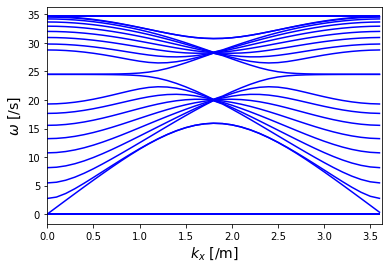

In [6]:
import numpy as np
import numpy.linalg as la

# Experimental setup
M = 0.01 # g
C = 4. # N/m
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1 = np.sqrt(3) * a * x
a2 = (np.sqrt(3) * x + 3 * y) * a / 2.
R1 = 1 / 3 * (a1 + a2)
R2 = 1 / 3 * (-2 * a1 + a2)
R3 = 1 / 3 * (a1 - 2 * a2)
R1h = R1 / la.norm(R1)
R2h = R2 / la.norm(R2)
R3h = R3 / la.norm(R3)
R11 = R1h * R1h.conj().T
R22 = R2h * R2h.conj().T
R33 = R3h * R3h.conj().T
xmax = np.pi / np.sqrt(3) * 2
precision = 0.1
kxs = np.arange(0, xmax, precision) 


# System specific parameters
N = 9 # number of unit cells

evals_all, evecs_all  = [], []
for kx in kxs:
    k = np.array([kx, 0.])
    p = np.exp(1.j * k.dot(a1))

    H = np.zeros((N * 2 * 2, N * 2 * 2), dtype=np.complex128)
    L = np.vstack([
        np.hstack([R11 + R22 + R33, -R11 - R22 * p]),
        np.hstack([-R11 - R22 * p.conj(), R11 + R22 + R33]),
    ])

    for i in range(0, N * 2 * 2, 4):
        H[i:i+4, i:i+4] = L
    for i in range(0, N * 2 * 2 - 2, 2):
        if (i / 2) % 2 != 0:
            H[i:i+2, i+2:i+4] = -R33
            H[i+2:i+4, i:i+2] = -R33

    # Solve eigenvalue equation
    evals, evecs = la.eigh(w0**2 * H)
    idcs = np.argsort(evals)
    evals, evecs = evals[idcs], evecs[idcs]
    evals_all.append(evals)
    evecs_all.append(evecs)
evals_all, evecs_all = np.array(evals_all, dtype=np.complex128), np.array(evecs_all, dtype=np.complex128)
print(evals_all.shape, evecs_all.shape)


import matplotlib.pyplot as plt
# fig = plt.figure()
for i in range(evals_all.shape[1]):
    plt.plot(kxs, np.sqrt(evals_all[:, i]).real, color='blue')
plt.xlabel(r"$k_x$ [/m]", fontsize=14)
plt.xlim(0, xmax)
plt.ylabel(r"$\omega$ [/s]", fontsize=14)
plt.show()
# fig.savefig("1d-dispersion-coriolis-06.png")

#### 1.2.1.1. Visualize eigenvectors

(37, 36) (37, 36, 36)


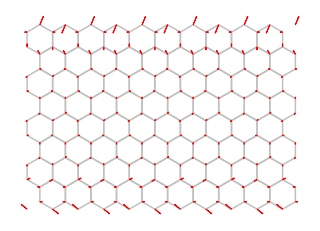

In [7]:
import numpy as np
import numpy.linalg as la

# Experimental setup
M = 1. # g
C = 1. # N/m
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1 = np.sqrt(3) * a * x
a2 = (np.sqrt(3) * x + 3 * y) * a / 2.
R1 = 1 / 3 * (a1 + a2)
R2 = 1 / 3 * (-2 * a1 + a2)
R3 = 1 / 3 * (a1 - 2 * a2)
R1h = R1 / la.norm(R1)
R2h = R2 / la.norm(R2)
R3h = R3 / la.norm(R3)
R11 = R1h * R1h.conj().T
R22 = R2h * R2h.conj().T
R33 = R3h * R3h.conj().T
xmax = np.pi / np.sqrt(3) * 2
precision = 0.1
kxs = np.arange(0, xmax, precision) 


# System specific parameters
N = 9 # number of unit cells

evals_all, evecs_all  = [], []
for kx in kxs:
    k = np.array([kx, 0.])
    p = np.exp(1.j * k.dot(a1))

    H = np.zeros((N * 2 * 2, N * 2 * 2), dtype=np.complex128)
    L = np.vstack([
        np.hstack([R11 + R22 + R33, -R11 - R22 * p]),
        np.hstack([-R11 - R22 * p.conj(), R11 + R22 + R33]),
    ])

    for i in range(0, N * 2 * 2, 4):
        H[i:i+4, i:i+4] = L
    for i in range(0, N * 2 * 2 - 2, 2):
        if (i / 2) % 2 != 0:
            H[i:i+2, i+2:i+4] = -R33
            H[i+2:i+4, i:i+2] = -R33

    # Solve eigenvalue equation
    evals, evecs = la.eigh(w0**2 * H)
    idcs = np.argsort(evals)
    evals, evecs = evals[idcs], evecs[idcs]
    evals_all.append(evals)
    evecs_all.append(evecs)
evals_all, evecs_all = np.array(evals_all, dtype=np.complex128), np.array(evecs_all, dtype=np.complex128)
print(evals_all.shape, evecs_all.shape)


### Plot eigenvectors ###
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1_ = 2 * np.pi / np.sqrt(3) / a * (x - y / np.sqrt(3)) 
a2_ = 4 * np.pi / 3 / a * y
G = np.array([[0.], [0.]])
K = (a1_ / 2 + a2_ / 4) / np.cos(np.pi / 6)**2
M = a1_ / 2

# Parameters #
kx = M[0] 
ky = M[1] 
# print(np.sqrt(evals_all[: 18]).real)
mode = 23 # 1 or 2
###############

a1 = np.sqrt(3) * a * np.array([1, 0])
a2 = (np.sqrt(3) * np.array([1, 0]) + 3 * np.array([0, 1])) * a / 2.

k = np.array([kx[0], ky[0]])
p = np.exp(1.j * k.dot(a1))
s = np.exp(1.j * k.dot(a2))
idx = min(range(len(kxs)), key=lambda i: abs(kxs[i]-kx[0]))
vec = evecs_all[idx, mode]



import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

dx = np.sqrt(3)
dy = 3
offCoord = [
    [dx * x + np.sqrt(3), dy * y + 1] for y in range(4) for x in range(10)
]
offCoord.extend([
    [dx * x + np.sqrt(3) / 2, dy * y + 2.5] for y in range(4) for x in range(10)
])

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

for c in offCoord:
    hexagon = RegularPolygon((c[0], c[1]), numVertices=6, radius=a, ec='silver', fill=False, lw=1.5)
    ax.add_patch(hexagon)
plt.autoscale(enable = True)


def arrow(pos, vec):
    ax.arrow(pos[0], pos[1], vec[0], vec[1], head_width=0.05, head_length=0.1, fc='black', ec='red')

for j in range(11):
    for power, i in enumerate(range(0, 9, 2)):
        xi = vec[i*4:i*4+2]
        eta = vec[i*4+2:i*4+4]
        xi_ = (xi * p**(power+j)).real
        eta_ = (eta * p**(power+j)).real
        arrow([0., 3 * power] + a1 * j, xi_)
        arrow(np.squeeze(R1) + [0, 3 * power] + a1 * j, eta_)
    for power, i in enumerate(range(1, 9, 2)):
        xi = vec[i*4:i*4+2]
        eta = vec[i*4+2:i*4+4]
        xi_ = (xi * p**(power+j)).real
        eta_ = (eta * p**(power+j+1)).real
        xi_ = (xi * p**i).real
        arrow(np.squeeze(R1) + [0, 1 + 3 * power] + a1 * j, xi_)
        arrow([0., 3 * power + 2] + a1 * j, eta_)

plt.axis('off')
plt.show()
plt.show()

### 1.2.2. Coriolis 

(37, 72) (37, 72, 72)


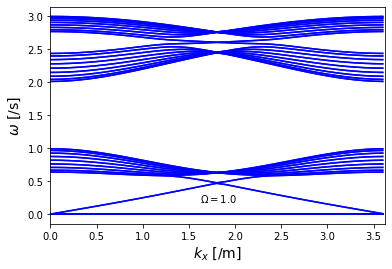

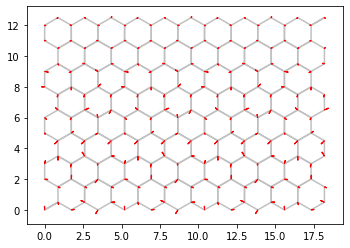

In [8]:
import numpy as np
import numpy.linalg as la

# Experimental setup
O = 1.
M = 1. # g
C = 1. # N/m
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1 = np.sqrt(3) * a * x
a2 = (np.sqrt(3) * x + 3 * y) * a / 2.
R1 = 1 / 3 * (a1 + a2)
R2 = 1 / 3 * (-2 * a1 + a2)
R3 = 1 / 3 * (a1 - 2 * a2)
Rw = np.array([[0., -1.], [1., 0.]])
R1h = R1 / la.norm(R1)
R2h = R2 / la.norm(R2)
R3h = R3 / la.norm(R3)
R11 = R1h * R1h.conj().T
R22 = R2h * R2h.conj().T
R33 = R3h * R3h.conj().T
xmax = np.pi / np.sqrt(3) * 2
precision = 0.1
kxs = np.arange(0, xmax, precision) 


# System specific parameters
N = 9 # number of unit cells
evec_size = 2
evec_num = 4

evals_all, evecs_all  = [], []
for kx in kxs:
    k = np.array([kx, 0.])
    p = np.exp(1.j * k.dot(a1))

    # Build Hamiltonian
    L11 = np.vstack([
        np.hstack([R11 + R22 + R33, -(R11 + p.conj() * R22)]),
        np.hstack([-(R11 + p * R22), R11 + R22 + R33])
    ])
    L12 = np.vstack([
        np.hstack([-Rw * 2.j * O, np.zeros((2, 2))]),
        np.hstack([np.zeros((2, 2)), -Rw * 2.j * O])
    ])
    L = w0 ** 2 * np.vstack([
        np.hstack([L11, L12]),
        np.hstack([np.zeros((4, 4)), np.eye(4)])
    ])
    C = np.vstack([
        np.hstack([np.zeros((2, 2)), -R33]),
        np.zeros((2, 4))
    ])
    Cb = np.vstack([
        np.hstack([C, np.zeros((4, 4))]),
        np.zeros((4, 8))
    ])

    ss = evec_size * evec_num # size of the sublattice, 8 in this case
    dim = N * evec_size * evec_num
    H = np.zeros((dim, dim), dtype=np.complex128)

    for i in range(0, dim, 8):
        H[i:i+ss, i:i+ss] = L
    for i in range(8, dim, 8):
        H[i:i+ss, i-ss:i] = Cb
        H[i-ss:i, i:i+ss] = Cb.T

    M = np.zeros((dim, dim), dtype=np.complex128)
    for i in range(0, dim, 8):
        M_ = np.vstack([
            np.hstack([np.zeros((4, 4)), np.eye(4)]),
            np.hstack([np.eye(4), np.zeros((4, 4))])
        ])
        M[i:i+ss, i:i+ss] = M_

    M_inv = la.inv(M)
    H = w0**2 * H
    # Solve eigenvalue equation
    evals, evecs = la.eig(M_inv.dot(H))
    idcs = np.argsort(evals)
    evals, evecs = evals[idcs], evecs[idcs]
    evals_all.append(evals)
    evecs_all.append(evecs)
evals_all, evecs_all = np.array(evals_all, dtype=np.complex128), np.array(evecs_all, dtype=np.complex128)
print(evals_all.shape, evecs_all.shape)


import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(evals_all.shape[1]):
    plt.plot(kxs, abs(evals_all[:, i].real), color='blue')
plt.xlabel(r"$k_x$ [/m]", fontsize=14)
plt.xlim(0, xmax)
plt.figtext(.47, .2, r"$\Omega=$" + f'{O:.1f}', fontsize=10)
plt.ylabel(r"$\omega$ [/s]", fontsize=14)
plt.show()
# fig.savefig("mechanical-graphene-dispersion-coriolis-10.png")


#### Plot eigen vectors ####
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1_ = 2 * np.pi / np.sqrt(3) / a * (x - y / np.sqrt(3)) 
a2_ = 4 * np.pi / 3 / a * y
G = np.array([[0.], [0.]])
K = (a1_ / 2 + a2_ / 4) / np.cos(np.pi / 6)**2
M = a1_ / 2

# Parameters #
kx = K[0] 
ky = K[1] 
mode = 15 # 1 or 2
###############

a1 = np.sqrt(3) * a * np.array([1, 0])
a2 = (np.sqrt(3) * np.array([1, 0]) + 3 * np.array([0, 1])) * a / 2.

k = np.array([kx[0], ky[0]])
p = np.exp(1.j * k.dot(a1))
s = np.exp(1.j * k.dot(a2))
idx = min(range(len(kxs)), key=lambda i: abs(kxs[i]-kx[0]))
vec = evecs_all[idx, mode]



import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

dx = np.sqrt(3)
dy = 3
offCoord = [
    [dx * x + np.sqrt(3), dy * y + 1] for y in range(4) for x in range(10)
]
offCoord.extend([
    [dx * x + np.sqrt(3) / 2, dy * y + 2.5] for y in range(4) for x in range(10)
])

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

for c in offCoord:
    hexagon = RegularPolygon((c[0], c[1]), numVertices=6, radius=a, ec='silver', fill=False, lw=1.5)
    ax.add_patch(hexagon)
ax.arrow(0, 0, np.sqrt(3) / 2, 1 / 2, head_width=0, head_length=0, lw=1.5, ec='silver')
ax.arrow(10 * np.sqrt(3), 12, np.sqrt(3) / 2, 1 / 2, head_width=0, head_length=0, lw=1.5, ec='silver')
plt.autoscale(enable = True)


def arrow(pos, vec):
    ax.arrow(pos[0], pos[1], vec[0], vec[1], head_width=0.05, head_length=0.1, fc='black', ec='red')

for j in range(11):
    for power, i in enumerate(range(0, 9, 2)):
        xi = vec[i*8:i*8+2]
        eta = vec[i*8+2:i*8+4]
        xi_ = (xi * p**(power+j)).real
        eta_ = (eta * p**(power+j)).real
        arrow([0., 3 * power] + a1 * j, xi_)
        arrow(np.squeeze(R1) + [0, 3 * power] + a1 * j, eta_)
    for power, i in enumerate(range(1, 9, 2)):
        xi = vec[i*8:i*8+2]
        eta = vec[i*8+2:i*8+4]
        xi_ = (xi * p**(power+j)).real
        eta_ = (eta * p**(power+j+1)).real
        xi_ = (xi * p**i).real
        arrow(np.squeeze(R1) + [0, 1 + 3 * power] + a1 * j, xi_)
        arrow([0., 3 * power + 2] + a1 * j, eta_)

# plt.axis('off')
plt.show()

### 1.2.3. Coriolis as a perturbation

(37, 36) (37, 36, 36)


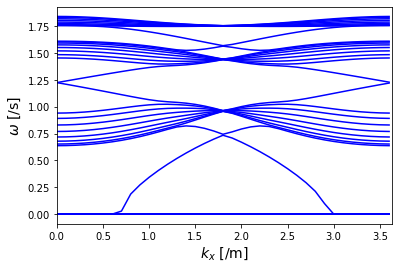

[0. 0.] [ 0.07418095 -0.10484803]
[0.8660254 0.5      ] [-0.06993834 -0.01990595]
[0. 3.] [-1.66617116e-03 -1.44146040e-16]
[0.8660254 3.5      ] [0.20541222 0.3298029 ]
[0. 6.] [-0.17538897 -0.12433992]
[0.8660254 6.5      ] [0.2074169  0.33089808]
[0. 9.] [-0.17917391 -0.12552135]
[0.8660254 9.5      ] [1.66439270e-03 9.50520455e-17]
[ 0. 12.] [ 0.12284458 -0.1969509 ]
[ 0.8660254 12.5      ] [-0.20001529  0.12512916]
[0.8660254 1.5      ] [ 0.12565896 -0.19783733]
[0. 2.] [-0.19965459  0.12456866]
[0.8660254 4.5      ] [-0.32770948 -0.20895556]
[0. 5.] [-0.03351583  0.11653108]
[0.8660254 7.5      ] [0.32479737 0.20164325]
[0. 8.] [-0.0245095   0.12373341]
[ 0.8660254 10.5      ] [ 0.07698748 -0.10964595]
[ 0. 11.] [0.0753612  0.01529998]
[1.73205081 0.        ] [-0.07418095  0.10484803]
[2.59807621 0.5       ] [0.06993834 0.01990595]
[1.73205081 3.        ] [1.66617116e-03 1.44146040e-16]
[2.59807621 3.5       ] [-0.20541222 -0.3298029 ]
[1.73205081 6.        ] [0.17538897 0.124339

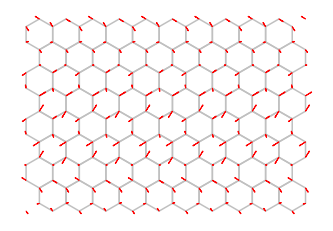

In [9]:
import numpy as np
import numpy.linalg as la

# Experimental setup
O = 0.2
M = 1. # g
C = 1. # N/m
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1 = np.sqrt(3) * a * x
a2 = (np.sqrt(3) * x + 3 * y) * a / 2.
R1 = 1 / 3 * (a1 + a2)
R2 = 1 / 3 * (-2 * a1 + a2)
R3 = 1 / 3 * (a1 - 2 * a2)
R1h = R1 / la.norm(R1)
R2h = R2 / la.norm(R2)
R3h = R3 / la.norm(R3)
R11 = R1h * R1h.conj().T
R22 = R2h * R2h.conj().T
R33 = R3h * R3h.conj().T
xmax = np.pi / np.sqrt(3) * 2
precision = 0.1
kxs = np.arange(0, xmax, precision) 

Rw = np.array([[0., -1.], [1., 0.]])

# System specific parameters
N = 9 # number of unit cells

evals_all, evecs_all  = [], []
for kx in kxs:
    k = np.array([kx, 0.])
    p = np.exp(1.j * k.dot(a1))

    H = np.zeros((N * 2 * 2, N * 2 * 2), dtype=np.complex128)
    # L = np.vstack([
    #     np.hstack([R11 + R22 + R33 - 2.j * O / w0**2, -R11 - R22 * p]),
    #     np.hstack([-R11 - R22 * p.conj(), R11 + R22 + R33 - 2.j * O / w0**2]),
    # ])
    L = np.vstack([
        np.hstack([R11 + R22 + R33 - 2.j * O * Rw / w0**2, -R11 - R22 * p]),
        np.hstack([-R11 - R22 * p.conj(), R11 + R22 + R33 - 2.j * O * Rw / w0**2]),
    ])

    for i in range(0, N * 2 * 2, 4):
        H[i:i+4, i:i+4] = L
    for i in range(0, N * 2 * 2 - 2, 2):
        if (i / 2) % 2 != 0:
            H[i:i+2, i+2:i+4] = -R33
            H[i+2:i+4, i:i+2] = -R33

    # Solve eigenvalue equation
    evals, evecs = la.eigh(w0**2 * H)
    idcs = np.argsort(evals)
    evals, evecs = evals[idcs], evecs[idcs]
    evals_all.append(evals)
    evecs_all.append(evecs)
evals_all, evecs_all = np.array(evals_all, dtype=np.complex128), np.array(evecs_all, dtype=np.complex128)
print(evals_all.shape, evecs_all.shape)


import matplotlib.pyplot as plt
# fig = plt.figure()
for i in range(evals_all.shape[1]):
    plt.plot(kxs, np.sqrt(evals_all[:, i]).real, color='blue')
plt.xlabel(r"$k_x$ [/m]", fontsize=14)
plt.xlim(0, xmax)
plt.ylabel(r"$\omega$ [/s]", fontsize=14)
plt.show()
# fig.savefig("1d-dispersion-coriolis-06.png")


### Plot eigenvectors ###
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat
a1_ = 2 * np.pi / np.sqrt(3) / a * (x - y / np.sqrt(3)) 
a2_ = 4 * np.pi / 3 / a * y
G = np.array([[0.], [0.]])
K = (a1_ / 2 + a2_ / 4) / np.cos(np.pi / 6)**2
M = a1_ / 2

# Parameters #
kx = M[0] 
ky = M[1] 
# print(np.sqrt(evals_all[: 18]).real)
mode = 30 # 1 or 2
###############

a1 = np.sqrt(3) * a * np.array([1, 0])
a2 = (np.sqrt(3) * np.array([1, 0]) + 3 * np.array([0, 1])) * a / 2.

k = np.array([kx[0], ky[0]])
p = np.exp(1.j * k.dot(a1))
s = np.exp(1.j * k.dot(a2))
idx = min(range(len(kxs)), key=lambda i: abs(kxs[i]-kx[0]))
vec = evecs_all[idx, mode]



import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

dx = np.sqrt(3)
dy = 3
offCoord = [
    [dx * x + np.sqrt(3), dy * y + 1] for y in range(4) for x in range(10)
]
offCoord.extend([
    [dx * x + np.sqrt(3) / 2, dy * y + 2.5] for y in range(4) for x in range(10)
])

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

for c in offCoord:
    hexagon = RegularPolygon((c[0], c[1]), numVertices=6, radius=a, ec='silver', fill=False, lw=1.5)
    ax.add_patch(hexagon)
plt.autoscale(enable = True)


def arrow(pos, vec):
    print(pos, vec)
    ax.arrow(pos[0], pos[1], vec[0], vec[1], head_width=0.05, head_length=0.1, fc='black', ec='red')

for j in range(11):
    for power, i in enumerate(range(0, 9, 2)):
        xi = vec[i*4:i*4+2]
        eta = vec[i*4+2:i*4+4]
        xi_ = (xi * p**(power+j)).real
        eta_ = (eta * p**(power+j)).real
        arrow([0., 3 * power] + a1 * j, xi_)
        arrow(np.squeeze(R1) + [0, 3 * power] + a1 * j, eta_)
    for power, i in enumerate(range(1, 9, 2)):
        xi = vec[i*4:i*4+2]
        eta = vec[i*4+2:i*4+4]
        xi_ = (xi * p**(power+j)).real
        eta_ = (eta * p**(power+j+1)).real
        xi_ = (xi * p**i).real
        arrow(np.squeeze(R1) + [0, 1 + 3 * power] + a1 * j, xi_)
        arrow([0., 3 * power + 2] + a1 * j, eta_)

plt.axis('off')
plt.show()

# 2. 1d
## 2.1. edge (Free boundary)
### 2.1.1. inertial frame of reference
#### 2.1.1.1. x,y

(48,) (48, 48)


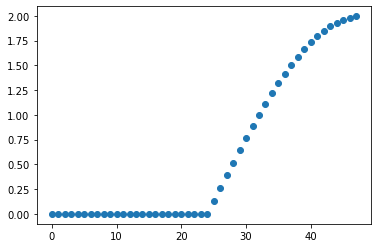

In [10]:
import numpy as np
import numpy.linalg as la

# Experimental setup
M = 1. # g
C = 1. # N/m
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat

precision = 0.1


# System specific parameters
N = 12 # number of unit cells


H = np.zeros((N * 2 * 2, N * 2 * 2), dtype=np.complex128)
L_fst = np.vstack([
    np.hstack([1, 0, -1, 0]),
    np.zeros((1, 4)),
    np.hstack([-1, 0, 2, 0]),
    np.zeros((1, 4))
])
L_last = np.vstack([
    np.hstack([2, 0, -1, 0]),
    np.zeros((1, 4)),
    np.hstack([-1, 0, 1, 0]),
    np.zeros((1, 4))
])

L = np.vstack([
    np.hstack([2, 0, -1, 0]),
    np.zeros((1, 4)),
    np.hstack([-1, 0, 2, 0]),
    np.zeros((1, 4))
])
C = np.array([[-1., 0.], [0., 0.]])
C_ = np.vstack([
    np.zeros((2, 4)),
    np.hstack([C, np.zeros((2,2))])
])
H[:4, :4] = L_fst
H[N*4-4:N*4, N*4-4:N*4] = L_last
for i in range(4, N * 2 * 2 - 4, 4):
    H[i:i+4, i:i+4] = L
for i in range(0, N * 2 * 2 - 4, 4):
    H[i:i+4, i+4:i+8] = C_
    H[i+4:i+8, i:i+4] = C_.T

# Solve eigenvalue equation
evals, evecs = la.eig(w0**2 * H)
idcs = np.argsort(evals)
evals, evecs = evals[idcs], evecs[idcs]

print(evals.shape, evecs.shape)

import matplotlib.pyplot as plt

plt.scatter(np.arange(len(evals)), np.sqrt(evals).real)
plt.show()


import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def draw_plot(mode: int):
    dx = 1
    offCoord = [[i * dx, 0.] for i in range(N * 2)]
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')

    for c in offCoord:
        hexagon = Circle((c[0], c[1]), radius=0.1, ec='silver', fill=False, lw=1.5)
        ax.add_patch(hexagon)

    plt.autoscale(enable = True)
    for i in range(N):
        i_ = i * 2
        pos_xi = offCoord[i_]
        pos_eta = offCoord[i_ + 1]
        i_ = i * 4
        xi = evecs[mode][i_:i_+2].real
        eta = evecs[mode][i_+2:i_+4].real
        ax.arrow(pos_xi[0], pos_xi[1], xi[0], xi[1], width=0.02, head_width=0.1, head_length=0.1, fc='r', ec='r')
        ax.arrow(pos_eta[0], pos_eta[1], eta[0], eta[1], width=0.02, head_width=0.1, head_length=0.1, fc='r', ec='r')
    plt.axis('off')
    plt.show()

# for i, e in enumerate(evals):
#     print(i, e)
#     draw_plot(i)

#### 2.1.1.2. with x only

(16,) (16, 16)


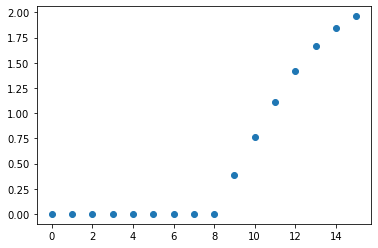

In [11]:
import numpy as np
import numpy.linalg as la

# Experimental setup
M = 1. # g
C = 1. # N/m
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat

precision = 0.1


# System specific parameters
N = 4 # number of unit cells


H = np.zeros((N * 2 * 2, N * 2 * 2), dtype=np.complex128)
L_fst = np.vstack([
    np.hstack([1, -1]),
    np.hstack([-1, 2]),
])
L_last = np.vstack([
    np.hstack([2, -1]),
    np.hstack([-1, 1]),
])

L = np.vstack([
    np.hstack([2, -1]),
    np.hstack([-1, 2]),
])
C = np.array([[0., 0.], [-1, 0.]])
H[:2, :2] = L_fst
H[N*2-2:N*2, N*2-2:N*2] = L_last
for i in range(2, N * 2 - 2, 2):
    H[i:i+2, i:i+2] = L
for i in range(0, N * 2 - 2, 2):
    H[i:i+2, i+2:i+4] = C
    H[i+2:i+4, i:i+2] = C.T

# Solve eigenvalue equation
evals, evecs = la.eig(w0**2 * H)
idcs = np.argsort(evals)
evals, evecs = evals[idcs], evecs[idcs]

print(evals.shape, evecs.shape)

import matplotlib.pyplot as plt

plt.scatter(np.arange(len(evals)), np.sqrt(evals).real)
plt.show()

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def draw_plot(mode: int):
    dx = 1
    offCoord = [[i * dx, 0.] for i in range(N * 2)]
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')

    for c in offCoord:
        hexagon = Circle((c[0], c[1]), radius=0.1, ec='silver', fill=False, lw=1.5)
        ax.add_patch(hexagon)

    plt.autoscale(enable = True)
    for i in range(N):
        i_ = i * 2
        pos_xi = offCoord[i_]
        pos_eta = offCoord[i_ + 1]
        i_ = i * 2
        xi = evecs[mode][i_].real
        eta = evecs[mode][i_+1].real
        ax.arrow(pos_xi[0], pos_xi[1], 0, xi, width=0.02, head_width=0.1, head_length=0.1, fc='r', ec='r')
        ax.arrow(pos_eta[0], pos_eta[1], 0, eta, width=0.02, head_width=0.1, head_length=0.1, fc='r', ec='r')
    plt.axis('off')
    plt.show()

# for i, e in enumerate(evals):
#     print(i, e)
#     draw_plot(i)


### 2.1.2. non-inertial reference frame

(96,) (96, 96)


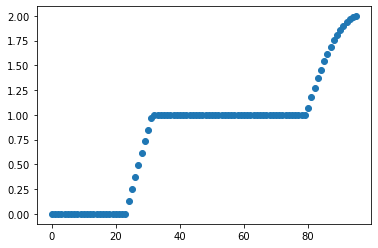

0 0.0


1 0.0


2 0.0


3 0.0


4 0.0


5 0.0


6 0.0


7 0.0


8 0.0


9 0.0


10 0.0


11 0.0


12 0.0


13 0.0


14 0.0


15 0.0


16 0.0


17 0.0


18 0.0


19 0.0


20 0.0


21 0.0


22 0.0


23 0.0


24 0.12558103905862691


25 0.25066646712860885


26 0.37476262917144965


27 0.49737977432971


28 0.6180339887498947


29 0.7362491053693571


30 0.8515585831301457


31 0.9635073482034305


32 1.0


33 1.0


34 1.0


35 1.0


36 1.0


37 1.0


38 1.0


39 1.0


40 1.0


41 1.0


42 1.0


43 1.0


44 1.0


45 1.0


46 1.0


47 1.0


48 1.0


49 1.0


50 1.0


51 1.0


52 1.0


53 1.0


54 1.0


55 1.0


56 1.0


57 1.0


58 1.0


59 1.0


60 1.0


61 1.0


62 1.0


63 1.0


64 1.0


65 1.0


66 1.0


67 1.0


68 1.0


69 1.0


70 1.0


71 1.0


72 1.0


73 1.0


74 1.0


75 1.0


76 1.0


77 1.0


78 1.0


79 1.0


80 1.0716535899579938


81 1.1755705045849458


82 1.274847979497379


83 1.3690942118573777


84 1.457937254842823


85 1.54102648555158


86 1.6180339887498956


87 1.68865585100403


88 1.7526133600877278


89 1.8096541049320392


90 1.8595529717765034


91 1.902113032590307


92 1.9371663222572617


93 1.9645745014573772


94 1.9842294026289566


95 1.9960534568565436


In [12]:
import numpy as np
import numpy.linalg as la

# Experimental setup
O = 14
M = 1. # g
C = 1. # N/m
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat

precision = 0.1


# System specific parameters
N = 12 # number of unit cells
H = np.zeros((N * 2 * 2, N * 2 * 2), dtype=np.complex128)
L = np.vstack([
    np.hstack([R11 + R22 + R33 - 2.j * O / w0**2, -R11 - R22 * p]),
    np.hstack([-R11 - R22 * p.conj(), R11 + R22 + R33 - 2.j * O / w0**2]),
])

for i in range(0, N * 2 * 2, 4):
    H[i:i+4, i:i+4] = L
for i in range(0, N * 2 * 2 - 2, 2):
    if (i / 2) % 2 != 0:
        H[i:i+2, i+2:i+4] = -R33
        H[i+2:i+4, i:i+2] = -R33

H = np.zeros((N * 8, N * 8), dtype=np.complex128)
L11_fst = np.vstack([
    np.hstack([1, 0, -1, 0]),
    np.zeros((1, 4)),
    np.hstack([-1, 0, 2, 0]),
    np.zeros((1, 4))
])
L11_last = np.vstack([
    np.hstack([2, 0, -1, 0]),
    np.zeros((1, 4)),
    np.hstack([-1, 0, 1, 0]),
    np.zeros((1, 4))
])
L11 = np.vstack([
    np.hstack([2, 0, -1, 0]),
    np.zeros((1, 4)),
    np.hstack([-1, 0, 2, 0]),
    np.zeros((1, 4))
])
Rw = np.array([[0., -1.], [1., 0.]])
L12 = np.vstack([
    np.hstack([-Rw * 2.j * O, np.zeros((2, 2))]),
    np.hstack([np.zeros((2, 2)), -Rw * 2.j * O])
])
L = w0 ** 2 * np.vstack([
    np.hstack([L11, L12]),
    np.hstack([np.zeros((4, 4)), np.eye(4)])
])
L_fst = w0 ** 2 * np.vstack([
    np.hstack([L11, L12]),
    np.hstack([np.zeros((4, 4)), np.eye(4)])
])
L_last = w0 ** 2 * np.vstack([
    np.hstack([L11, L12]),
    np.hstack([np.zeros((4, 4)), np.eye(4)])
])
C = np.array([[-1., 0.], [0., 0.]])
C_ = np.vstack([
    np.hstack([np.zeros((2, 2)), C]),
    np.zeros((2, 4))
])
Cb = np.vstack([
    np.hstack([C_, np.zeros((4,4))]),
    np.zeros((4, 8)),
])


transverse = False
if transverse:
    L11_fst = np.vstack([
        np.array([1, 0, -1, 0]),
        .1 * np.array([0, 1, 0, -1]),
        np.array([-1, 0, 2, 0]),
        .1 * np.array([0, -1, 0, 2]),
    ])
    L11_last = np.vstack([
        np.array([2, 0, -1, 0]),
        .1 * np.array([0, 2, 0, -1]),
        np.array([-1, 0, 1, 0]),
        .1 * np.array([0, -1, 0, 1]),
    ])
    L11 = np.vstack([
        np.array([2, 0, -1, 0]),
        .1 * np.array([0, 2, 0, -1]),
        .1 * np.array([-1, 0, 2, 0]),
        np.array([0, -1, 0, 2]),
    ])
    Rw = np.array([[0., -1.], [1., 0.]])
    L12 = np.vstack([
        np.hstack([-Rw * 2.j * O, np.zeros((2, 2))]),
        np.hstack([np.zeros((2, 2)), -Rw * 2.j * O])
    ])
    L = w0 ** 2 * np.vstack([
        np.hstack([L11, L12]),
        np.hstack([np.zeros((4, 4)), np.eye(4)])
    ])
    L_fst = w0 ** 2 * np.vstack([
        np.hstack([L11_fst, L12]),
        np.hstack([np.zeros((4, 4)), np.eye(4)])
    ])
    L_last = w0 ** 2 * np.vstack([
        np.hstack([L11_last, L12]),
        np.hstack([np.zeros((4, 4)), np.eye(4)])
    ])
    C = np.array([[-1., 0.], [0., -1.]])
    C_ = np.vstack([
        np.hstack([np.zeros((2, 2)), C]),
        np.zeros((2, 4))
    ])
    Cb = np.vstack([
        np.hstack([C_, np.zeros((4,4))]),
        np.zeros((4, 8)),
    ])

H[:8, :8] = L_fst
H[N*8-8:N*8, N*8-8:N*8] = L_last
for i in range(8, N * 8 - 8, 8):
    H[i:i+8, i:i+8] = L
for i in range(8, N * 8, 8):
    H[i:i+8, i-8:i] = Cb
    H[i-8:i, i:i+8] = Cb.T

# Solve eigenvalue equation
evals, evecs = la.eig(w0**2 * H)
idcs = np.argsort(evals)
evals, evecs = evals[idcs], evecs[idcs]

print(evals.shape, evecs.shape)

import matplotlib.pyplot as plt

plt.scatter(np.arange(len(evals)), np.sqrt(evals).real)
plt.show()

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def draw_plot(mode: int):
    dx = 1
    offCoord = [[i * dx, 0.] for i in range(N * 2)]
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')

    for c in offCoord:
        hexagon = Circle((c[0], c[1]), radius=0.1, ec='silver', fill=False, lw=1.5)
        ax.add_patch(hexagon)

    plt.autoscale(enable = True)
    for i in range(N):
        i_ = i * 2
        pos_xi = offCoord[i_]
        pos_eta = offCoord[i_ + 1]
        i_ = i * 8
        # xi = evecs[mode][i_:i_+2].real
        # eta = evecs[mode][i_+2:i_+4].real
        xi = evecs[i_:i_+2, mode].real
        eta = evecs[i_+2:i_+4, mode].real
        ax.arrow(pos_xi[0], pos_xi[1], xi[0], xi[1], width=0.02, head_width=0.1, head_length=0.1, fc='r', ec='r')
        ax.arrow(pos_eta[0], pos_eta[1], eta[0], eta[1], width=0.02, head_width=0.1, head_length=0.1, fc='r', ec='r')
    plt.axis('off')
    plt.show()

for i, e in enumerate(evals):
    print(i, np.sqrt(e).real)
    draw_plot(i)

#### 2.1.2.1. Coriolis as a perturbation

(48,) (48, 48)


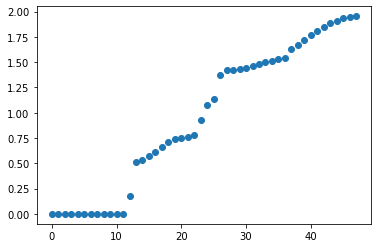

0 1.6553757161331004e-17


1 1.5799631565004936e-17


2 2.890055095347287e-18


3 2.8959205484749878e-18


4 5.498699745998138e-18


5 2.372588178040851e-17


6 2.20330974879747e-17


7 3.0044460816602704e-17


8 6.857666394244779e-17


9 3.0331835216816004e-17


10 3.1759764778251085e-17


11 1.4729343020431307e-16


12 0.17283529926725172


13 0.513543973037262


14 0.5360367683340228


15 0.5712587464072184


16 0.6151111071951251


17 0.6621197890508332


18 0.7069102361286373


19 0.7404597787721012


20 0.7542884273956496


21 0.7644994335881602


22 0.7781637023021004


23 0.9287220053329744


24 1.0774762980194843


25 1.1337789152971913


26 1.3754708769121282


27 1.4203952820860961


28 1.4215347503514082


29 1.4333303783170575


30 1.4435423400749527


31 1.4605349983747211


32 1.4804870424846726


33 1.500169716292877


34 1.5160841673654473


35 1.5269540127872947


36 1.5400549411896387


37 1.6304689836722448


38 1.67052488995712


39 1.71742596825438


40 1.7645884911487997


41 1.808911716577587


42 1.8486631738431363


43 1.8827815257843978


44 1.9106018934135858


45 1.9317273209852273


46 1.9459738366330295


47 1.9534805989576716


In [13]:
import numpy as np
import numpy.linalg as la

# Experimental setup
O = 0.4
M = 1. # g
C = 1. # N/m
w0 = np.sqrt(C / M)
a = 1. # distance between masses
x = np.array([[1.], [0.]]) # x hat
y = np.array([[0.], [1.]]) # y hat

precision = 0.1


# System specific parameters
N = 12 # number of unit cells


H = np.zeros((N * 4, N * 4), dtype=np.complex128)


Ct = 0.3


L11_fst = np.vstack([
    np.array([1, 0, -1, 0]),
    Ct * np.array([0, 1, 0, -1]),
    np.array([-1, 0, 2, 0]),
    Ct * np.array([0, -1, 0, 2]),
])
L11_last = np.vstack([
    np.array([2, 0, -1, 0]),
    Ct * np.array([0, 2, 0, -1]),
    np.array([-1, 0, 1, 0]),
    Ct * np.array([0, -1, 0, 1]),
])
L11 = np.vstack([
    np.array([2, 0, -1, 0]),
    Ct * np.array([0, 2, 0, -1]),
    Ct * np.array([-1, 0, 2, 0]),
    np.array([0, -1, 0, 2]),
])
Rw = np.array([[0., -1.], [1., 0.]])
L12 = np.vstack([
    np.hstack([-Rw * 2.j * O, np.zeros((2, 2))]),
    np.hstack([np.zeros((2, 2)), -Rw * 2.j * O])
])
L = w0 ** 2 * (L11 + L12)
L_fst = w0 ** 2 * (L11_fst + L12)
L_last = w0 ** 2 * (L11_last + L12)
C = np.array([[-1., 0.], [0., -1.]])
C_ = np.vstack([
    np.hstack([np.zeros((2, 2)), C]),
    np.zeros((2, 4))
])

H[:4, :4] = L_fst
H[N*4-4:N*4, N*4-4:N*4] = L_last
for i in range(4, N * 4 - 4, 4):
    H[i:i+4, i:i+4] = L
for i in range(4, N * 4, 4):
    H[i:i+4, i-4:i] = C_
    H[i-4:i, i:i+4] = C_.T

# Solve eigenvalue equation
evals, evecs = la.eig(w0**2 * H)
idcs = np.argsort(evals)
evals, evecs = evals[idcs], evecs[idcs]

print(evals.shape, evecs.shape)

import matplotlib.pyplot as plt

plt.scatter(np.arange(len(evals)), np.sqrt(evals).real)
plt.show()

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def draw_plot(mode: int):
    dx = 1
    offCoord = [[i * dx, 0.] for i in range(N * 2)]
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')

    for c in offCoord:
        hexagon = Circle((c[0], c[1]), radius=0.1, ec='silver', fill=False, lw=1.5)
        ax.add_patch(hexagon)

    plt.autoscale(enable = True)
    for i in range(N):
        i_ = i * 2
        pos_xi = offCoord[i_]
        pos_eta = offCoord[i_ + 1]
        i_ = i * 4
        # xi = evecs[mode][i_:i_+2].real
        # eta = evecs[mode][i_+2:i_+4].real
        xi = evecs[i_:i_+2, mode].real
        eta = evecs[i_+2:i_+4, mode].real
        ax.arrow(pos_xi[0], pos_xi[1], xi[0], xi[1], width=0.02, head_width=0.1, head_length=0.1, fc='r', ec='r')
        ax.arrow(pos_eta[0], pos_eta[1], eta[0], eta[1], width=0.02, head_width=0.1, head_length=0.1, fc='r', ec='r')
    plt.axis('off')
    plt.show()

for i, e in enumerate(evals):
    print(i, np.sqrt(e).real)
    draw_plot(i)